In [86]:
%reload_ext autoreload
%autoreload 2

### 1. Import library

In [87]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder


### 2. Import UCI dataset, and preprocessing

In [88]:
# column names
column_names = [
    "age", "workclass", "fnlwgt", "education", "education-num", "marital-status",
    "occupation", "relationship", "race", "sex", "capital-gain", "capital-loss",
    "hours-per-week", "native-country", "income"
]

# import dataset from adult.data
df = pd.read_csv('UCI_dataset/adult.data', header=None, names=column_names, skipinitialspace=True)
df = df.dropna()

# 0 represents <=50K, 1 represents >50K
df['income'] = df['income'].map({'<=50K': 0, '>50K': 1})
# 1 represents Male, 0 represents Female
df['sex'] = df['sex'].map({'Male': 1, 'Female': 0})
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,1,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,1,0,0,13,United-States,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,1,0,0,40,United-States,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,1,0,0,40,United-States,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,0,0,0,40,Cuba,0


In [123]:
# 数值和类别特征列
numeric_features = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
categorical_features = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'native-country']

# 数据分割
X = df.drop('income', axis=1)
y = df['income']
# 10% X_labeled, 90% X_unlabeled
X_labeled, X_unlabeled, y_labeled, y_unlabeled = train_test_split(X, y, test_size=0.9, random_state=25) 

# scaler
scaler = StandardScaler()
X_label_numeric = scaler.fit_transform(X_labeled[numeric_features])
X_unlabel_numeric = scaler.transform(X_unlabeled[numeric_features])
X_label_numeric_df = pd.DataFrame(X_label_numeric, columns=numeric_features)  # , index=X_labeled.index  means keep the same index
X_unlabel_numeric_df = pd.DataFrame(X_unlabel_numeric, columns=numeric_features) # , index=X_unlabeled.index

# one-hot encoder
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_categorical = encoder.fit_transform(X[categorical_features])
# get feature names after one-hot encoding
encoded_feature_names = encoder.get_feature_names_out(categorical_features)
X_categorical_df = pd.DataFrame(X_categorical, columns=encoded_feature_names)

X_label_categorical = encoder.transform(X_labeled[categorical_features])
X_label_categorical_df = pd.DataFrame(X_label_categorical, columns=encoded_feature_names)
X_unlabel_categorical = encoder.transform(X_unlabeled[categorical_features])
X_unlabel_categorical_df = pd.DataFrame(X_unlabel_categorical, columns=encoded_feature_names)

# Sex column
sex_column_label = X_labeled['sex']
sex_column_unlabel = X_unlabeled['sex']
sex_column_label = sex_column_label.reset_index(drop=True)
sex_column_unlabel = sex_column_unlabel.reset_index(drop=True)

# combine numeric and categorical features
X_label_processed = pd.concat((X_label_numeric_df, sex_column_label, X_label_categorical_df), axis=1)
X_unlabel_processed = pd.concat((X_unlabel_numeric_df,sex_column_unlabel, X_unlabel_categorical_df), axis=1)
print(f'X_label_processed shape: {X_label_processed.shape}')
print(f'X_unlabel_processed shape: {X_unlabel_processed.shape}')

# get the list of feature names and Risk name
combined_columns = list(X_label_processed.columns) + ['income']
print(f'combined_columns: {combined_columns}')

X_label_processed shape: (3256, 106)
X_unlabel_processed shape: (29305, 106)
combined_columns: ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'sex', 'workclass_?', 'workclass_Federal-gov', 'workclass_Local-gov', 'workclass_Never-worked', 'workclass_Private', 'workclass_Self-emp-inc', 'workclass_Self-emp-not-inc', 'workclass_State-gov', 'workclass_Without-pay', 'education_10th', 'education_11th', 'education_12th', 'education_1st-4th', 'education_5th-6th', 'education_7th-8th', 'education_9th', 'education_Assoc-acdm', 'education_Assoc-voc', 'education_Bachelors', 'education_Doctorate', 'education_HS-grad', 'education_Masters', 'education_Preschool', 'education_Prof-school', 'education_Some-college', 'marital-status_Divorced', 'marital-status_Married-AF-spouse', 'marital-status_Married-civ-spouse', 'marital-status_Married-spouse-absent', 'marital-status_Never-married', 'marital-status_Separated', 'marital-status_Widowed', 'occupation_?', 'occupation_Adm-clerical

In [90]:
print(f'X_label_numeric_df.shape: {X_label_numeric_df.shape}')
print(f'sex_column_label.shape:{sex_column_label.shape}')
print(f'X_label_categorical_df.shape:{X_label_categorical_df.shape}')

X_label_numeric_df.shape: (3256, 5)
sex_column_label.shape:(3256,)
X_label_categorical_df.shape:(3256, 100)


In [116]:
X_label_processed.columns.shape

(106,)

In [169]:
y_labeled = y_labeled.reset_index(drop=True)
X_label_processed.head(3)

,age,education-num,capital-gain,capital-loss,hours-per-week,sex,workclass_?,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,2.419882,-0.045279,-0.143471,-0.217137,-0.461696,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,-0.321254,1.124799,-0.143471,-0.217137,1.182943,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.123255,-0.045279,-0.143471,-0.217137,0.360624,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [170]:
# split labeled data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X_label_processed, y_labeled, test_size=0.2, random_state=25) 

In [184]:
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')

X_train shape: (2604, 106)
X_test shape: (652, 106)


### 3. Train the model

In [171]:
model = XGBClassifier()  # 可以替换为 RandomForestClassifier() 等其他模型
model.fit(X_train,y_train)

# 预测和评估
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.8604294478527608


In [172]:
# sensitive feature in X_test
a_test =X_test['sex']

### 4. Fairness checking

In [173]:
from fairlearn.metrics import MetricFrame, selection_rate,false_positive_rate,true_positive_rate,false_negative_rate,true_negative_rate,count
metrics = {'accuracy': accuracy_score,
           'selection_rate': selection_rate,
           'false_positive_rate': false_positive_rate,
           'true_positive_rate': true_positive_rate,
           'false_negative_rate': false_negative_rate,
           'true_negative_rate': true_negative_rate,
              'count': count}

Test set fairness metrics (before mitigation):


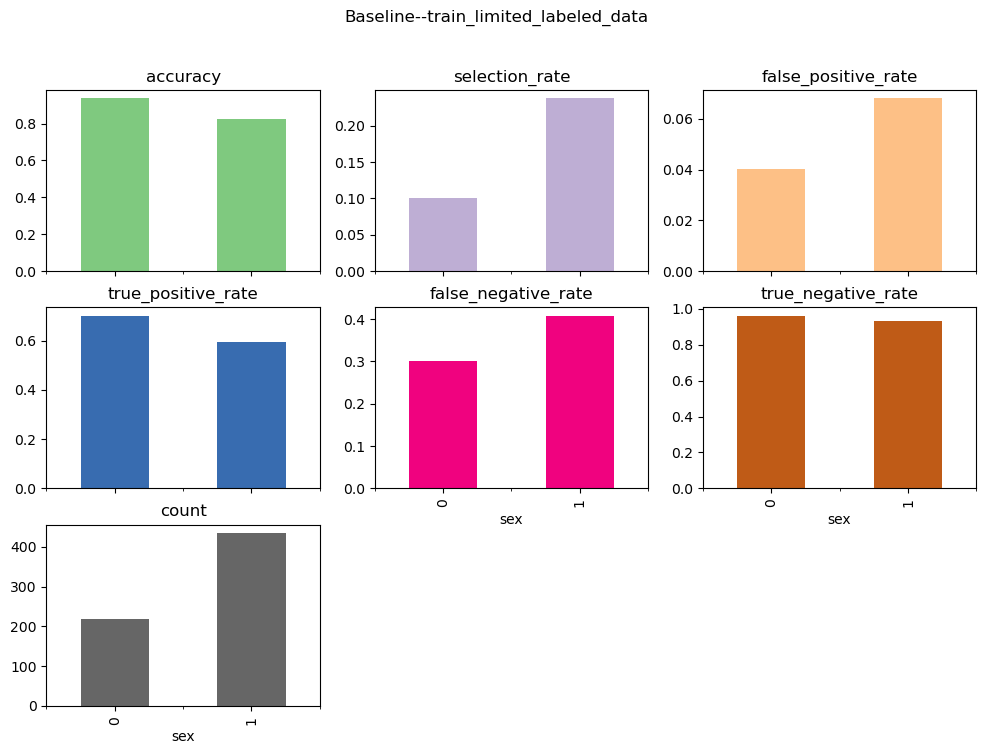

In [174]:
mf_original = MetricFrame(metrics=metrics,
                 y_true=y_test,
                 y_pred=y_pred,
                 sensitive_features=a_test)

print("Test set fairness metrics (before mitigation):")
mf_original.by_group.plot(
    kind="bar",
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    colormap="Accent",
    title="Baseline--train_limited_labeled_data",
)
diff = mf_original.by_group


In [204]:
import matplotlib.pyplot as plt
def plot_diff_accuracy(diff):
    # 提取 'accuracy' 列的两行值
    group0_value = diff.loc[0, 'accuracy']
    group1_value = diff.loc[1, 'accuracy']
    
    # 创建柱状图
    plt.figure(figsize=(6, 6))
    plt.bar(['Group 0', 'Group 1'], [group0_value, group1_value], color=['blue', 'orange'])
    plt.xlabel('Group')
    plt.ylabel('Accuracy')
    plt.title('Accuracy for Group 0 and Group 1')

    # 在每个条形顶部显示数值，保留三位小数
    for i, value in enumerate([group0_value, group1_value]):
        plt.text(i, value, f'{value:.3f}', ha='center', va='bottom')
    plt.show()

def plot_diff(diff):
    # 计算第一行和第二行的差值的绝对值
    diff = diff.drop(columns=['count'])
    diff_values = abs(diff.iloc[0] - diff.iloc[1])

    # 创建柱状图
    plt.figure(figsize=(10, 6))
    bars = plt.bar(diff.columns, diff_values)
    plt.xlabel('Column Names')
    plt.ylabel('Absolute Difference')
    plt.title('Absolute Difference Between First and Second Rows')
    plt.xticks(rotation=45)

    # 在每个条形顶部显示数值
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height,
                 f'{height:.3f}', ha='center', va='bottom')

    plt.show()


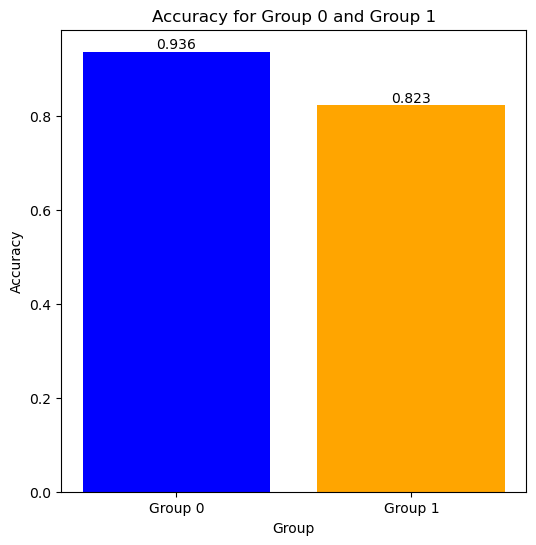

In [205]:
plot_diff_accuracy(diff)

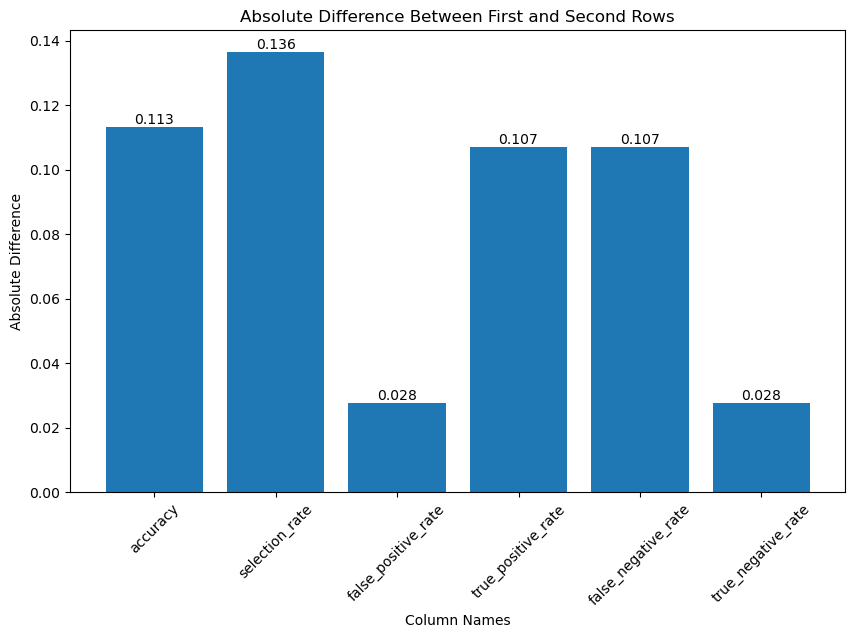

In [182]:
plot_diff(diff)

### 5. Fairness Attribution Module Test

In [206]:
from src.matching import NearestNeighborDataMatcher
matching = NearestNeighborDataMatcher(
    X_labeled=X_train,
    X_unlabeled=X_unlabel_processed
).match(n_neighbors=2)
print(f'matching shape: {matching.shape}')

matching shape: (2604, 29305)


In [207]:
from src.attribution import FairnessExplainer
sen_att_name = ["sex"]

sen_att = [X_train.columns.get_loc(name) for name in sen_att_name]
priv_val = [1]
unpriv_dict = [list(set(X_train.values[:, sa])) for sa in sen_att]
for sa_list, pv in zip(unpriv_dict, priv_val):
    sa_list.remove(pv)
print(f'sen_att_name:{sen_att_name}')
print(f'sen_att:{sen_att}') # index of sensitive attribute
print(f'priv_val:{priv_val}') # privileged value
print(f'unpriv_dict:{unpriv_dict}') # unprivileged value(all values in the sensitive attribute, except the privileged value)


sen_att_name:['sex']
sen_att:[5]
priv_val:[1]
unpriv_dict:[[0.0]]


In [208]:
fairness_explainer = FairnessExplainer(
    model=model, 
    sen_att=sen_att, 
    priv_val=priv_val, 
    unpriv_dict=unpriv_dict
    )
fairness_shap_values = fairness_explainer.shap_values(
    X=X_train.values,
    X_baseline=X_unlabel_processed.values,
    matching=matching,
    sample_size=400,
    shap_sample_size="auto",
)

In [209]:
print(f'X_train.shape: {X_train.shape}')
print(f'fairness_shap_values shape: {fairness_shap_values.shape}')  

X_train.shape: (2604, 106)
fairness_shap_values shape: (2604, 106)


In [210]:
fairness_shap_values

array([[ 1.66789943e-03,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 4.45329095e-03,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-7.43290439e-05,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [-8.06254074e-02,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 4.54023218e-04,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.02649927e-01,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

### 6. ※ Create new training dataset

In [254]:
### 1. get the varphi values
varphi = fairness_shap_values

### 2. use the datacomposer, get the q
from data_composer import DataComposer
q = DataComposer(x_counterfactual=X_unlabel_processed.values, joint_prob=matching, method="max").calculate_q()

### 3. choose limited_values , and get the location
import numpy as np
limited_values = 2604*100

flat_indices = np.argpartition(varphi.flatten(), -limited_values)[-limited_values:]
row_indices, col_indices = np.unravel_index(flat_indices, varphi.shape)

# change values
print(f'row_indices.shape:{row_indices.shape}')
print(f'col_indices.shape:{col_indices.shape}')

### 4. Find the values at these positions in q
q_values = q[row_indices, col_indices]
print(f'q_values.shape:{q_values.shape}')

### 5. add new data into the training set
X_observe_with_target = np.column_stack((X_train, y_train))
x_new = X_observe_with_target.copy()
for row_idx, col_idx, q_val in zip(row_indices, col_indices, q_values):
    x_new[row_idx, col_idx] = q_val

X_TRAIN_NEW = np.vstack((X_observe_with_target,x_new))
x_train_new = pd.DataFrame(X_TRAIN_NEW, columns=combined_columns)
print(f'X_TRAIN_NEW.shape:{X_TRAIN_NEW.shape}')

### 6. Train the model with new data
target_name = 'income'
x = x_train_new.drop(target_name, axis=1)
y = x_train_new[target_name]
print(f'x.shape:{x.shape}')
print(f'y.shape:{y.shape}')

row_indices.shape:(260400,)
col_indices.shape:(260400,)
q_values.shape:(260400,)
X_TRAIN_NEW.shape:(5208, 107)
x.shape:(5208, 106)
y.shape:(5208,)


### 7. Train the new model

In [255]:
model_new = XGBClassifier()  # 可以替换为 RandomForestClassifier() 等其他模型
model_new.fit(x, y)

# 预测和评估
y_pred_new = model_new.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_new)
print(f'Accuracy: {accuracy}')

Accuracy: 0.8573619631901841


Test set fairness metrics (after mitigation):


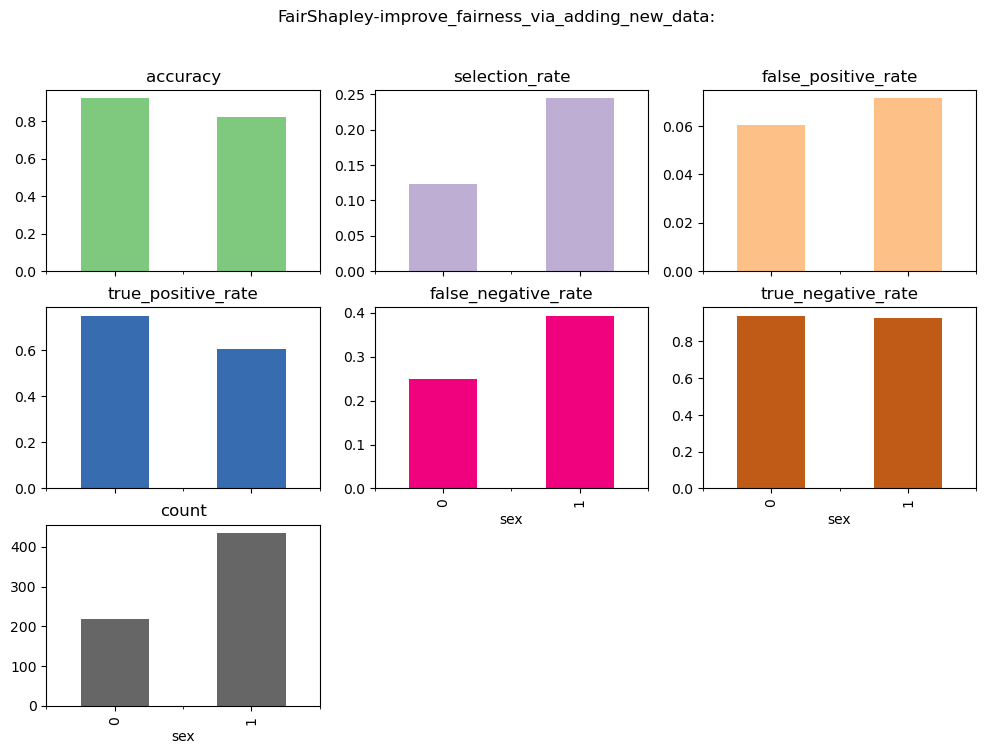

In [256]:
mf_original = MetricFrame(metrics=metrics,
                 y_true=y_test,
                 y_pred=y_pred_new,
                 sensitive_features=a_test)

print("Test set fairness metrics (after mitigation):")
mf_original.by_group.plot(
    kind="bar",
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    colormap="Accent",
    title="FairShapley-improve_fairness_via_adding_new_data:",
)
diff_new = mf_original.by_group

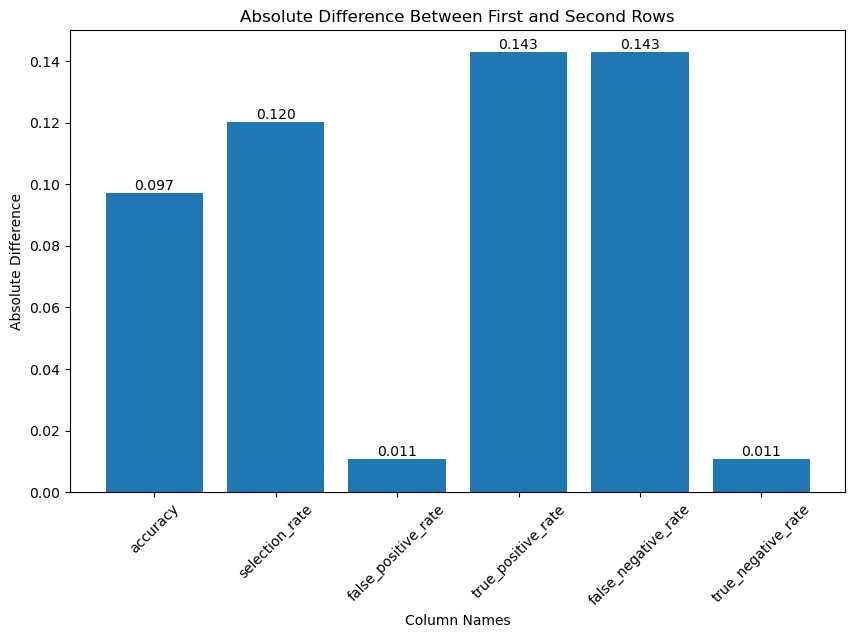

In [257]:
plot_diff(diff_new)

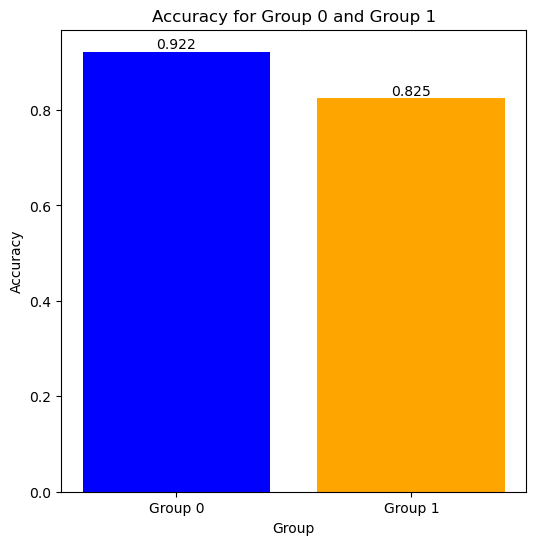

In [258]:
plot_diff_accuracy(diff_new)